In [3]:
import sys
import os
import torch
import torchaudio
import torch.optim as optim
import os
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from IPython.display import Audio
import torch.nn as nn
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchaudio import load
from pathlib import Path


In [4]:

sys.path.append('/Users/francesco/Library/CloudStorage/GoogleDrive-brigante.1987197@studenti.uniroma1.it/Altri computer/Il mio computer/uni/aml/Music-Source-Separation-for-an-Additional-Instrument')  # Replace with the actual path to the encodec directory
from encodec.seanet import SEANetEncoder, SEANetDecoder
# from encodec.mine_loss import CompositeLossWithAugmentation
from encodec.mine_loss import ReconstructionLoss

## Test

In [33]:
file_path = "musdb18_others/track_018_others.wav"
audio, sr = torchaudio.load(file_path)  
print(f"Audio shape: {audio.shape}, Sampling rate: {sr}")

Audio shape: torch.Size([2, 300032]), Sampling rate: 44100


In [24]:
if len(audio.shape) == 1:  
    audio = torch.tensor(audio).unsqueeze(0).unsqueeze(0)  
else: 
    audio = audio.unsqueeze(0) 

print(f"Audio tensor shape for model: {audio.shape}")


Audio tensor shape for model: torch.Size([1, 2, 300032])


n_filters is the # of filters in the first conv layer
dimension is the latent space dimension

final size before latent space is 300032 / (8x4x4x2) = 1172

number of channels doubles at each step. 4 steps (as the # of elements of ratio)
so starting from 32=2^5 we end up at 2^8=256

these channels are projected to the latent space of dim 128 (deafult)

In [25]:
ratios = [4, 4, 4, 2]

encoder = SEANetEncoder(channels=2, dimension=256, n_filters=64, ratios=ratios)
decoder = SEANetDecoder(channels=2, dimension=256, n_filters=64, ratios=ratios)

/opt/anaconda3/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
z = encoder(audio)  
print(f"Encoded latent shape: {z.shape}")

In [ ]:
audio_cpu = audio.squeeze().cpu()

print("Original Audio:")
Audio(audio_cpu.squeeze().numpy(), rate=sr) 


Original Audio:


In [ ]:
reconstructed_audio = decoder(z)
print(f"Reconstructed audio shape: {reconstructed_audio.shape}")

Reconstructed audio shape: torch.Size([1, 2, 300032])


In [31]:
reconstructed_cpu = reconstructed_audio.squeeze().cpu()
print("Reconstructed Audio:")
Audio(reconstructed_cpu.squeeze().detach().numpy(), rate=sr)


Reconstructed Audio:


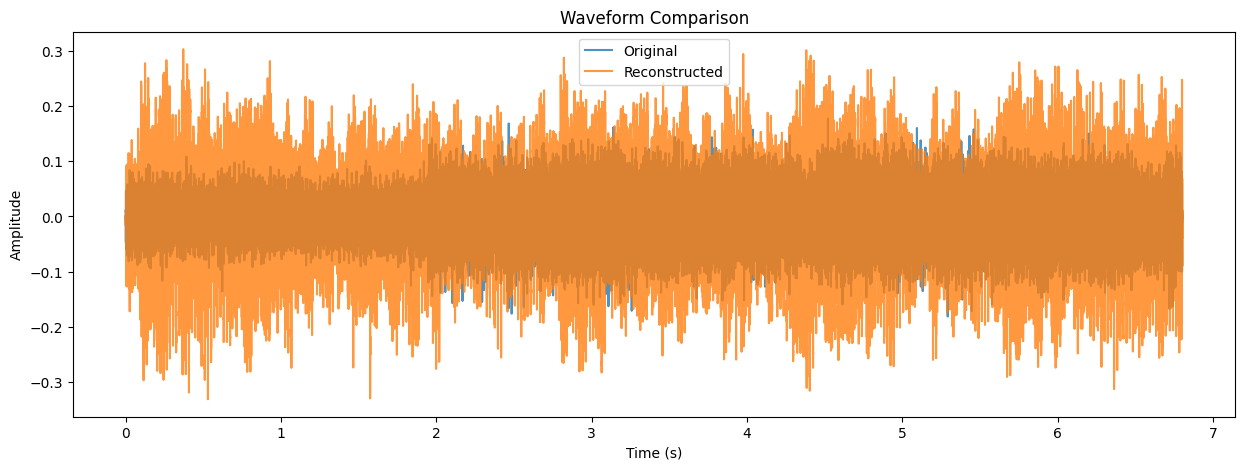

In [ ]:
import matplotlib.pyplot as plt

audio_plot = audio.squeeze(0)[0]  
reconstructed_audio_plot = reconstructed_audio.squeeze(0)[0]  

# Time axis for plotting
time = torch.arange(audio_plot.size(-1)).float() / sr

# Plot waveforms
plt.figure(figsize=(15, 5))
plt.plot(time, audio_plot, label="Original", alpha=0.8)
plt.plot(time, reconstructed_audio_plot.detach(), label="Reconstructed", alpha=0.8)
plt.title("Waveform Comparison")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [ ]:
# best model
checkpoint = torch.load("best_model_long2.pth", map_location='cpu')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Loaded best model from epoch {epoch} with loss {loss:.4f}")


/var/folders/g1/_jmd0tb55d58p50yyylwr0_00000gn/T/ipykernel_6323/724254942.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_long2.pth",

Loaded best model from epoch 24 with loss 0.1882


## Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class Musdb18Dataset(Dataset):
    def __init__(self, dataset_dir, sample_rate, normalize=True):
        self.dataset_dir = dataset_dir
        self.sample_rate = sample_rate
        self.normalize = normalize
        self.filepaths = list(Path(dataset_dir).glob("*.wav"))
    
    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        waveform, sr = torchaudio.load(filepath)
        
        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate).to(device)
            waveform = resampler(waveform)

        if self.normalize:
            waveform = self.normalize_waveform(waveform)

        return waveform

    def __len__(self):
        return len(self.filepaths) 

    def normalize_waveform(self, waveform):
        max_val = waveform.abs().max()
        return waveform / max_val


In [27]:
ratios = [4, 4, 4, 2]
encoder = SEANetEncoder(channels=2, dimension=512, n_filters=48, ratios=ratios)
decoder = SEANetDecoder(channels=2, dimension=512, n_filters=48, ratios=ratios, final_activation='Tanh')

In [11]:


dataset_dir = 'musdb18_others'

sample_rate = 16000
sample_rate = 44100
batch_size = 8
num_epochs = 8
learning_rate = 1e-4

dataset = Musdb18Dataset(dataset_dir, sample_rate=sample_rate, normalize=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

encoder = encoder.to(device)
decoder = decoder.to(device)
model = nn.Sequential(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = CompositeLossWithAugmentation(sample_rate).to(device)
criterion = ReconstructionLoss().to(device)


In [7]:
import time

start = time.time()
for i, batch in enumerate(dataloader):
    if i == 10:
        break
print(f"Time per batch: {(time.time() - start) / 10:.4f} seconds")


Time per batch: 0.0446 seconds


In [8]:
import torch.nn.init as init

def initialize_weights(m):
    """
    Applies Kaiming initialization for Conv/ReLU layers and Xavier for Tanh/Linear layers.
    """
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Conv2d):
        if hasattr(m, 'weight') and m.weight is not None:
            init.kaiming_uniform_(m.weight, nonlinearity='relu')  
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        if hasattr(m, 'weight') and m.weight is not None:
            init.xavier_uniform_(m.weight)  
        if m.bias is not None:
            init.uniform_(m.bias, -0.01, 0.01)
            
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)


SEANetDecoder(
  (model): Sequential(
    (0): SConv1d(
      (conv): NormConv1d(
        (conv): Conv1d(512, 768, kernel_size=(7,), stride=(1,))
        (norm): Identity()
      )
    )
    (1): SLSTM(
      (lstm): LSTM(768, 768, num_layers=2)
    )
    (2): ELU(alpha=1.0)
    (3): SConvTranspose1d(
      (convtr): NormConvTranspose1d(
        (convtr): ConvTranspose1d(768, 384, kernel_size=(8,), stride=(4,))
        (norm): Identity()
      )
    )
    (4): SEANetResnetBlock(
      (block): Sequential(
        (0): ELU(alpha=1.0)
        (1): SConv1d(
          (conv): NormConv1d(
            (conv): Conv1d(384, 192, kernel_size=(3,), stride=(1,))
            (norm): Identity()
          )
        )
        (2): ELU(alpha=1.0)
        (3): SConv1d(
          (conv): NormConv1d(
            (conv): Conv1d(192, 384, kernel_size=(1,), stride=(1,))
            (norm): Identity()
          )
        )
      )
      (shortcut): SConv1d(
        (conv): NormConv1d(
          (conv): Conv1d

In [ ]:
from tqdm import tqdm
import torch

criterion = ReconstructionLoss()
best_loss = float('inf')
best_model_path = "best_model3.pth"

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss_epoch = 0.0
    total_mse_loss = 0.0
    total_spec_loss = 0.0
    total_kl_loss = 0.0

    with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for batch_idx, batch in enumerate(dataloader):
            input_waveform = batch.to(device)

            # print(f"Original mean: {input_waveform.mean().item():.6f}, std: {input_waveform.std().item():.6f}")

            latent_vectors = encoder(input_waveform)
            print(f"Latent mean: {latent_vectors.mean().item():.6f}, std: {latent_vectors.std().item():.6f}")
            reconstructed_waveform = decoder(latent_vectors, input_length=input_waveform.shape[-1])
            print(f"Reconstructed mean: {reconstructed_waveform.mean().item():.6f}, std: {reconstructed_waveform.std().item():.6f}")
            loss, mse_loss, spec_loss, kl_loss = criterion(input_waveform, reconstructed_waveform, latent_vectors)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_norm=1.0)
            optimizer.step()

            total_loss_epoch += loss.item()
            total_mse_loss += mse_loss.item()
            total_spec_loss += spec_loss.item()
            total_kl_loss += kl_loss.item()

            avg_loss_so_far = total_loss_epoch / (batch_idx + 1)
            pbar.set_postfix({"Loss": avg_loss_so_far})
            pbar.update(1)
            
    criterion.step()

    avg_loss_epoch = total_loss_epoch / len(dataloader)
    avg_mse_loss = total_mse_loss / len(dataloader)
    avg_spec_loss = total_spec_loss / len(dataloader)
    avg_kl_loss = total_kl_loss / len(dataloader)

    if avg_loss_epoch < best_loss:
        best_loss = avg_loss_epoch
        torch.save({
            'epoch': epoch + 1,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, best_model_path)
        print(f"  New best model saved with total loss: {best_loss:.4f}")

    print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
    print(f"  Total Loss: {avg_loss_epoch:.4f}")
    print(f"  MSE Loss: {avg_mse_loss:.4f}, Spectrogram Loss: {avg_spec_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")
